# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import networkx as nx
import os
import plotly.express as px
from fink_utils.photometry.conversion import dc_mag
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from datetime import datetime
from scipy.optimize import curve_fit
import copy
from gatspy import periodic
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import datetime

# Import data and keep only the more important features

In [2]:
liste = [
    'EB*', 'Mira', 'SN candidate', 'QSO', 'BLLac', 'Blazar',
    'RRLyr', 'YSO', 'LPV*', 'AGN','Seyfert_1', 'AGN_Candidate', 'TTau*', 'CataclyV*'
] 
#deleted 'Early SN Ia candidate', 'Microlensing candidate'

#define df as an empty dataframe
df = pd.DataFrame()

dossier = '/home/centos/data/data_march'
name = {}
count = 0
for nom_fichier in liste:
    chemin = os.path.join(dossier, "finkclass=" + nom_fichier)
    print("loading", nom_fichier, "...")

    if nom_fichier != 'CataclyV*':
        temp = pd.read_parquet([chemin + "/" + os.listdir(chemin)[i] for i in range(min(10, len(os.listdir(chemin))))])

    else:
        temp = pd.read_parquet([chemin + "/" + os.listdir(chemin)[i] for i in range(len(os.listdir(chemin)))])
        
    #add a column with the name of the file
    name[nom_fichier.split('=')[-1]] = count
    count += 1
    
    #concatenate the dataframes
    df = pd.concat([df, temp], ignore_index=True)

kilonova = pd.read_parquet('/home/centos/data/balanced_data/finkclass=Kilonova candidate')
ambiguous = pd.read_parquet('/home/centos/data/balanced_data/finkclass=Ambiguous')
SN = pd.read_parquet('/home/centos/data/balanced_data/finkclass=SN candidate')

#Add a column 'finkclass' with the value Kilonova candidate
kilonova['finkclass'] = 'Kilonova candidate'
ambiguous['finkclass'] = 'Ambiguous'
SN['finkclass'] = 'SN candidate'
df = pd.concat([df, kilonova, SN], ignore_index=True)


loading EB* ...


<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject


loading Mira ...
loading SN candidate ...
loading QSO ...
loading BLLac ...
loading Blazar ...
loading RRLyr ...
loading YSO ...
loading LPV* ...
loading AGN ...
loading Seyfert_1 ...
loading AGN_Candidate ...
loading TTau* ...
loading CataclyV* ...


In [3]:
variable_star_class = ['EB*', 'Mira', 'RRLyr', 'YSO', 'LPV*', "TTau*"]
AGN_class = ['QSO', 'BLLac', 'Blazar', 'AGN', 'Seyfert_1', 'AGN_Candidate']

def define_meta_class(ele):
    if ele in variable_star_class:
        ele = "Variable Star"

    elif ele in AGN_class:
        ele = "AGN"

    return ele

#for every items in df change the value of the column 'finkclass' by applying the function define_meta_class
df['finkclass'] = df['finkclass'].apply(define_meta_class)


In [4]:
#take the first 500 elements of each class
df = df.groupby('finkclass').head(200)
df = df.reset_index(drop=True)
print(df['finkclass'].value_counts())


Variable Star         200
SN candidate          200
AGN                   200
CataclyV*             200
Kilonova candidate    183
Name: finkclass, dtype: int64


In [5]:
# extract columns of interest
cols = [
    'rf_kn_vs_nonkn',
    'rf_snia_vs_nonia',
    'snn_sn_vs_all',
    'snn_snia_vs_nonia'
]


cols_in_candidate = [
    'jdstarthist',
    'magpsf',
    'sigmapsf',
    'fid', 
    'magnr', 
    'sigmagnr', 
    'isdiffpos',
    'neargaia',
    'sgscore1',
    'classtar'
]


# Adding the alert ZTF23aaaatwl

In [138]:
import requests
import pandas as pd
import io
# get data for ZTF19acnjwgm
r = requests.post(
    'https://fink-portal.org/api/v1/objects',
    json={
        'objectId': 'ZTF23aaaatwl',
        'withupperlim': True,
        'output-format': 'json'
    }
)

pdf = pd.read_json(io.BytesIO(r.content))

temp = []

for col in cols:
    temp.append('d:' + col)

for col in cols_in_candidate:
    temp.append('i:' + col)

In [139]:
from fink_science.ad_features.processor import extract_features_ad_raw

def extract(pdf):
    # moment de la detection d'anomalie
    t0 = pdf[pdf['d:anomaly_score'] == np.min(pdf['d:anomaly_score'])]['i:jd'].values[0]

    # donnees 30 jours avant l'anomalie
    pdf_anomalous = pdf[(pdf['i:jd'] >= t0 - 30) & (pdf['i:jd'] <= t0)]

    if type(pdf['i:objectId']) != str:
        id = pdf['i:objectId'].values[0]

    else:
        id = pdf['i:objectId']

    features = extract_features_ad_raw(
    pdf['i:magpsf'], 
    pdf['i:jd'], 
    pdf['i:sigmapsf'], 
    pdf['i:fid'], 
    id
    )

    #create a df with every element of the dictionnary located in df['lc_features_g']
    if 1 in features:
        green = pd.DataFrame([features[1]])

    else:
        green = pd.DataFrame()

    #create a df with every element of the dictionnary located in df['lc_features_g']
    if 2 in features:
        red = pd.DataFrame([features[2]])

    else:
        red = pd.DataFrame()

    #rename every column of df_lc_features_g and df_lc_features_r by adding _g and _r after
    green = green.add_suffix('_g')
    red = red.add_suffix('_r')

    return pd.concat([green, red], axis=1)

In [140]:
to_add = pdf[temp][pdf['d:anomaly_score'] == np.min(pdf['d:anomaly_score'])]
to_add = to_add.reset_index(drop=True)

anomaly = pd.concat([to_add, extract(pdf)], axis=1)

In [141]:
r = requests.post(
  'https://fink-portal.org/api/v1/anomaly',
  json={
    'n': 10, # Optional. Number of objects to retrieve between `stop_date` and `start_date`. Default is 10.
    'start_date': "2023-06-09", # Optional. YYYY-MM-DD. Default is 2023-01-25
    'stop_date': "2023-06-01", # Optional. YYYY-MM-DD. Default is today
    'output-format': 'json'
  }
)

# Format output in a DataFrame
oids = [i['i:objectId'] for i in r.json()]

# retrieve full objects data
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': ','.join(oids),
    'output-format': 'json'
  }
)


# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

In [142]:
#create sub dataframe for every unique object_id
sous_datasets = []
for value in pdf['i:objectId'].unique():
    sous_datasets.append(pdf[pdf['i:objectId'] == value].copy())

In [143]:
for i in range(len(sous_datasets)):
  to_add = sous_datasets[i][temp][sous_datasets[i]['d:anomaly_score'] == np.min(sous_datasets[i]['d:anomaly_score'])]
  to_add = to_add.reset_index(drop=True)
  features = extract(sous_datasets[i])
  to_add = pd.concat([to_add, features], axis=1)
  anomaly = pd.concat([anomaly, to_add], axis = 0)

In [144]:
#when a column start with a letter and then :, suppress the letter and the :
anomaly.columns = [col[2:] if col[1] == ':' else col for col in anomaly.columns]

In [13]:
oids

['ZTF18aazndjw',
 'ZTF17aabpimd',
 'ZTF18aazrofd',
 'ZTF18abizzqe',
 'ZTF18aakhgsc',
 'ZTF18abghrpw',
 'ZTF19aascumi',
 'ZTF19aawhnhy',
 'ZTF20aaspijy',
 'ZTF19acsbxgd']

In [30]:
#save anomaly as a parquet file
anomaly.to_parquet('/home/centos/data/anomaly.parquet')

In [6]:
anomaly = pd.read_parquet('/home/centos/data/anomaly.parquet')

## Colormaping

In [7]:
name_meta = {'Variable Star': 0,
 'AGN': 1,
 'SN candidate': 2,
 'Kilonova candidate': 3,
 'CataclyV*': 4,
 'Ambiguous': 5}

#create a list with len(name) different colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(name_meta)))

#for every key in the dictionnary name, change name[key] by colors[ind]
for ind, key in enumerate(name_meta):
    name_meta[key] = colors[ind]

# Keep the most important features according to PCA

In [9]:
#extract columns of interest in df
df_filt = df[cols]
ambiguous_filt = ambiguous[cols]

#create a df with the columns of interest in candidate which are located in df['candidate']
df_candidate = pd.DataFrame(df['candidate'].tolist(), columns=cols_in_candidate)
ambiguous_candidate = pd.DataFrame(ambiguous['candidate'].tolist(), columns=cols_in_candidate)

#create a df with every element of the dictionnary located in df['lc_features_g']
df_lc_features_g = pd.DataFrame(df['lc_features_g'].tolist())
ambiguous_lc_features_g = pd.DataFrame(ambiguous['lc_features_g'].tolist())

#create a df with every element of the dictionnary located in df['lc_features_g']
df_lc_features_r = pd.DataFrame(df['lc_features_r'].tolist())
ambiguous_lc_features_r = pd.DataFrame(ambiguous['lc_features_r'].tolist())

#rename every column of df_lc_features_g and df_lc_features_r by adding _g and _r after
df_lc_features_g = df_lc_features_g.add_suffix('_g')
df_lc_features_r = df_lc_features_r.add_suffix('_r')
ambiguous_lc_features_g = ambiguous_lc_features_g.add_suffix('_g')
ambiguous_lc_features_r = ambiguous_lc_features_r.add_suffix('_r')

#concatenate the two dataframes
df_filt = pd.concat([df_filt, df_candidate, df_lc_features_g, df_lc_features_r], axis=1)
ambiguous_filt = pd.concat([ambiguous_filt, ambiguous_candidate, ambiguous_lc_features_g, ambiguous_lc_features_r], axis=1)

#in the column isdiffpos, replace t by 1 and f by -1
df_filt['isdiffpos'] = df_filt['isdiffpos'].replace({'t': 1, 'f': -1})
anomaly['isdiffpos'] = anomaly['isdiffpos'].replace({'t': 1, 'f': -1})
ambiguous_filt['isdiffpos'] = ambiguous_filt['isdiffpos'].replace({'t': 1, 'f': -1})

#Normalizing data
anomaly = (anomaly - df_filt.mean()) / df_filt.std()
ambiguous_filt = (ambiguous_filt - df_filt.mean()) / df_filt.std()
df_filt = (df_filt - df_filt.mean()) / df_filt.std()


#replace None or NaN by 0
anomaly = anomaly.fillna(0)
df_filt = df_filt.fillna(0)
ambiguous_filt = ambiguous_filt.fillna(0)

#do a pca and show variance explained
n_components = 20

pca = PCA(n_components=n_components)
pca.fit(df_filt)

label = df['finkclass']

In [10]:
#take a random sample of 200 elements in df_filt_selected and label
temp = df_filt.sample(n=200, random_state=42)
df_filt_selected_sample = pca.transform(temp)
label_sample = label[temp.index]

#create an other sample with 200 different elements of df_filt_selected and label
temp2 = df_filt.drop(temp.index)
temp2 = temp2.sample(n=200, random_state=42)
df_filt_selected_sample2 = pca.transform(temp2)
label_sample2 = label[temp2.index]

#change anomaly
anomaly = anomaly.reindex(columns=df_filt.columns)
anomaly_filt_selected = pca.transform(anomaly)
anomaly_filt_selected = pd.DataFrame(anomaly_filt_selected)

#change ambiguous
ambiguous_filt = ambiguous_filt.reindex(columns=df_filt.columns)
ambiguous_filt_selected = pca.transform(ambiguous_filt)
ambiguous_filt_selected = pd.DataFrame(ambiguous_filt_selected)
ambiguous_filt_selected.index += len(df)

In [11]:
#transform df_filt_selected_sample and df_filt_selected_sample2 in a dataframe
df_filt_selected_sample = pd.DataFrame(df_filt_selected_sample)
df_filt_selected_sample2 = pd.DataFrame(df_filt_selected_sample2)

In [12]:
#change index of df_filt_selected_sample2 to have the same index as temp2
df_filt_selected_sample2.index = temp2.index
df_filt_selected_sample.index = temp.index

In [13]:
#creating a X_train containing all pair of X_train
X_train = []
y_train = []
for i in range(len(df_filt_selected_sample)):
    for j in range(i+1, len(df_filt_selected_sample)):
        X_train.append([df_filt_selected_sample.iloc[i].to_list(), df_filt_selected_sample.iloc[j].to_list()])
        y_train.append(1 if label_sample.iloc[i] == label_sample.iloc[j] else 0)

X_test = []
y_test = []
for i in range(len(df_filt_selected_sample)):
    for j in range(i+1, len(df_filt_selected_sample)):
        X_test.append([df_filt_selected_sample.iloc[i].to_list(), df_filt_selected_sample.iloc[j].to_list()])
        y_test.append(1 if label_sample.iloc[i] == label_sample.iloc[j] else 0)

In [14]:
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    
    def __len__(self):
        return self.length

trainset = dataset(X_train, y_train)
#DataLoader
trainloader = DataLoader(trainset, batch_size=16, shuffle=False)

testset = dataset(X_test, y_test)
#DataLoader
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [15]:
#create a neural network that take a element of X_train with size (2, 22) and predict the labels with a fc layer with 22 neurons

class Net(nn.Module):
    def __init__(self, nb_variables):
        super(Net, self).__init__()
        self.nb_variables = nb_variables
        self.stack = nn.Sequential(nn.Linear(2*nb_variables, 4*nb_variables),
        nn.ReLU(),
        nn.Linear(4*nb_variables, 2*nb_variables),
        nn.ReLU(),
        nn.Linear(2*nb_variables, 1),
        nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 2*self.nb_variables)
        x = self.stack(x)

        return x

net = Net(20)

#print the archetecture of the neural network
print(net)

#print the number of parameters
print(sum(p.numel() for p in net.parameters() if p.requires_grad))

Net(
  (stack): Sequential(
    (0): Linear(in_features=40, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
6561


In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred[:,0], y)

        # Backpropagation (always in three steps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch %1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred[:,0], y).item()
            pred = torch.tensor([1 if pred[i] > 0.5 else 0 for i in range(len(pred))])
            correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return 100*(1-correct)

In [17]:
# Hyperparameters
learning_rate = 0.001
epochs = 200
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

In [51]:
error = []

for t in range(10):
    print(f"Epoch {t+1}-----------------")
    # Use train_loop and test_loop functions
    train_loop(trainloader, net, loss_fn, optimizer)
    x = test_loop(testloader, net, loss_fn)
    error.append(x)
print("Done!")

Epoch 1-----------------
loss: 0.000000  [    0/19900]
loss: 0.000038  [16000/19900]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001760
Epoch 2-----------------
loss: 0.000000  [    0/19900]
loss: 0.010995  [16000/19900]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.002862
Epoch 3-----------------
loss: 0.000000  [    0/19900]
loss: 0.001137  [16000/19900]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.002016
Epoch 4-----------------
loss: 0.000000  [    0/19900]
loss: 0.000112  [16000/19900]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000158
Epoch 5-----------------
loss: 0.000000  [    0/19900]
loss: 0.000002  [16000/19900]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000450
Epoch 6-----------------
loss: 0.000000  [    0/19900]
loss: 0.000003  [16000/19900]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.052152
Epoch 7-----------------
loss: 0.000000  [    0/19900]
loss: 0.000008  [16000/19900]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.008632
Epoch 8-----------------
loss: 0.000000  [    0/1990

In [82]:
torch.save(net.state_dict(), 'results/models/model.pt')

In [18]:
checkpoint = torch.load('results/models/model.pt')
net.load_state_dict(checkpoint)

<All keys matched successfully>

# Graphs !

## Plot the graph !

Ano1 is linked with 4 Variable Star
Ano1 is linked with 2 AGN
Ano1 is linked with 20 SN candidate
Ano1 is linked with 19 CataclyV*
Ano1 is linked with 1 Kilonova candidate
Ano2 is linked with 1 Variable Star
Ano2 is linked with 4 CataclyV*
Ano3 is linked with 24 Variable Star
Ano3 is linked with 16 AGN
Ano3 is linked with 33 CataclyV*
Ano4 is linked with 4 Variable Star
Ano4 is linked with 37 AGN
Ano4 is linked with 5 CataclyV*
Ano5 is linked with 2 SN candidate
Ano5 is linked with 3 CataclyV*
Ano5 is linked with 9 Kilonova candidate
Ano6 is linked with 1 AGN
Ano6 is linked with 4 SN candidate
Ano6 is linked with 12 Kilonova candidate
Ano7 is linked with 10 Variable Star
Ano7 is linked with 19 CataclyV*
Ano8 is linked with 11 Variable Star
Ano8 is linked with 19 CataclyV*
Ano9 is linked with 5 Variable Star
Ano9 is linked with 11 AGN
Ano9 is linked with 2 SN candidate
Ano9 is linked with 23 CataclyV*
Ano10 is linked with 1 Variable Star
Ano10 is linked with 24 AGN
Ano10 is linked with 

/home/centos/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


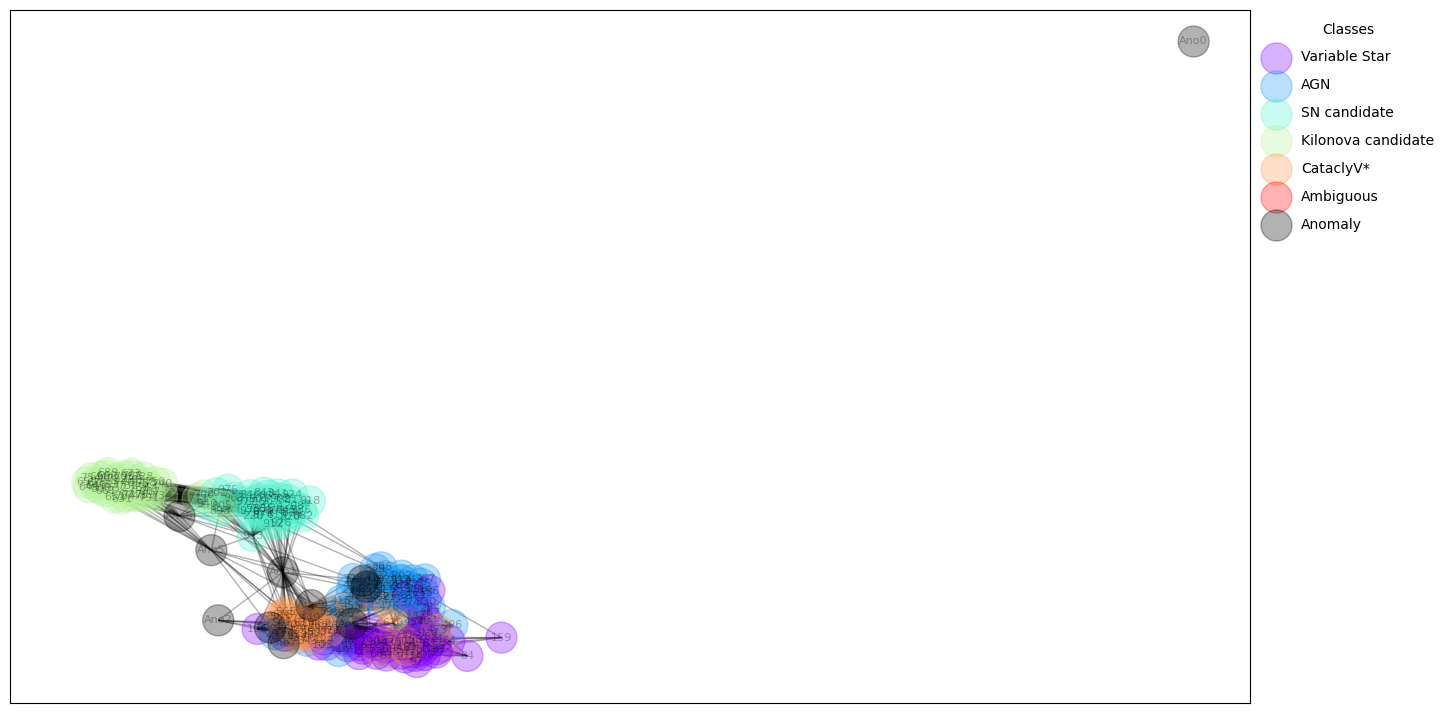

In [19]:
#defining the graph
G = nx.Graph()

#defining colors
plt.figure(figsize=(16,9))
color_map = []

#change color of each node according to their type
G.add_nodes_from(df_filt_selected_sample2.index)

for node in G: 
    ele = name_meta[df['finkclass'][node]]
    color_map.append(ele)

for ind, key in enumerate(name_meta):
    plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)


dict_edges = {}
for i in range(len(df_filt_selected_sample2) + len(anomaly)):
    dict_edges[i] = {}
    
for i in range(len(df_filt_selected_sample2)):
    
    for j in range(i+1, len(df_filt_selected_sample2)):
        pred = float(net(torch.tensor([[df_filt_selected_sample2.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))
        if pred > 0.5:
            G.add_edge(df_filt_selected_sample2.index[i], df_filt_selected_sample2.index[j])
            

            dict_edges[i][j] = pred
            dict_edges[j][i] = pred


if True:
    #adding anomaly edges
    plt.scatter([],[], color="black", alpha=0.3, s=500, label="Anomaly")

    count = 0
    for i in range(len(anomaly)):
        G.add_node("Ano" + str(i))
        color_map.append("black")
        count_meta = {'Variable Star': 0,
                'AGN': 0,
                'SN candidate': 0,
                'CataclyV*': 0,
                'Kilonova candidate': 0}
        for j in range(len(df_filt_selected_sample2)):
            pred = float(net(torch.tensor([[anomaly_filt_selected.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))

            if pred > 0.5:
                G.add_edge("Ano" + str(i), df_filt_selected_sample2.index[j])
                

                dict_edges[len(df_filt_selected_sample2) + i][j] = pred
                dict_edges[j][len(df_filt_selected_sample2) + i] = pred

                count_meta[df['finkclass'][df_filt_selected_sample2.index[j]]] += 1

        for key, ind in count_meta.items():
            if ind != 0:
                print("Ano" + str(i), "is linked with", ind, key)

        count += sum(count_meta.values())

    print(count, "anomaly edges added over", int(len(df_filt_selected_sample2)**2), "possible edges ie", int((count/len(df_filt_selected_sample2)**2)*100), "%")

    count = 0          
    for i in range(len(anomaly)):
        for j in range(i + 1, len(anomaly)):

            pred = float(net(torch.tensor([[anomaly_filt_selected.iloc[i].to_list(), anomaly_filt_selected.iloc[j].to_list()]], dtype=torch.float32)))

            if pred > 0.5:
                G.add_edge("Ano" + str(i), "Ano" + str(j))
                

                dict_edges[len(df_filt_selected_sample2) + i][len(df_filt_selected_sample2) + j] = pred
                dict_edges[len(df_filt_selected_sample2) + j][len(df_filt_selected_sample2) + i] = pred
                count += 1
                print("Ano" + str(i), "Ano" + str(j), "are linked !")

    print(count, "anomaly edges added over", int(len(anomaly) * (len(anomaly) - 1) / 2), "possible edges ie", int((count/(len(anomaly) * (len(anomaly) - 1) / 2)*100)), "%")

    #filtering the nodes without edges
    nodes_with_edges = []
    filtered_color = []
    i = 0

    at_least_one = False
    for node in G.nodes():
        at_least_one = False
        if len(G.edges(node)) > 0:
            nodes_with_edges.append(node)
            filtered_color.append(color_map[i])
            at_least_one = True

        if not at_least_one:
            print(node, "has no edges")
        

        i += 1

nx.draw_networkx(G, with_labels=True, node_color=color_map, node_size=500, alpha=0.3, font_size=8)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [20]:
#take randomly 20 elements in the df ambiguous
ambiguous_sample = ambiguous_filt_selected.sample(20, random_state=42)

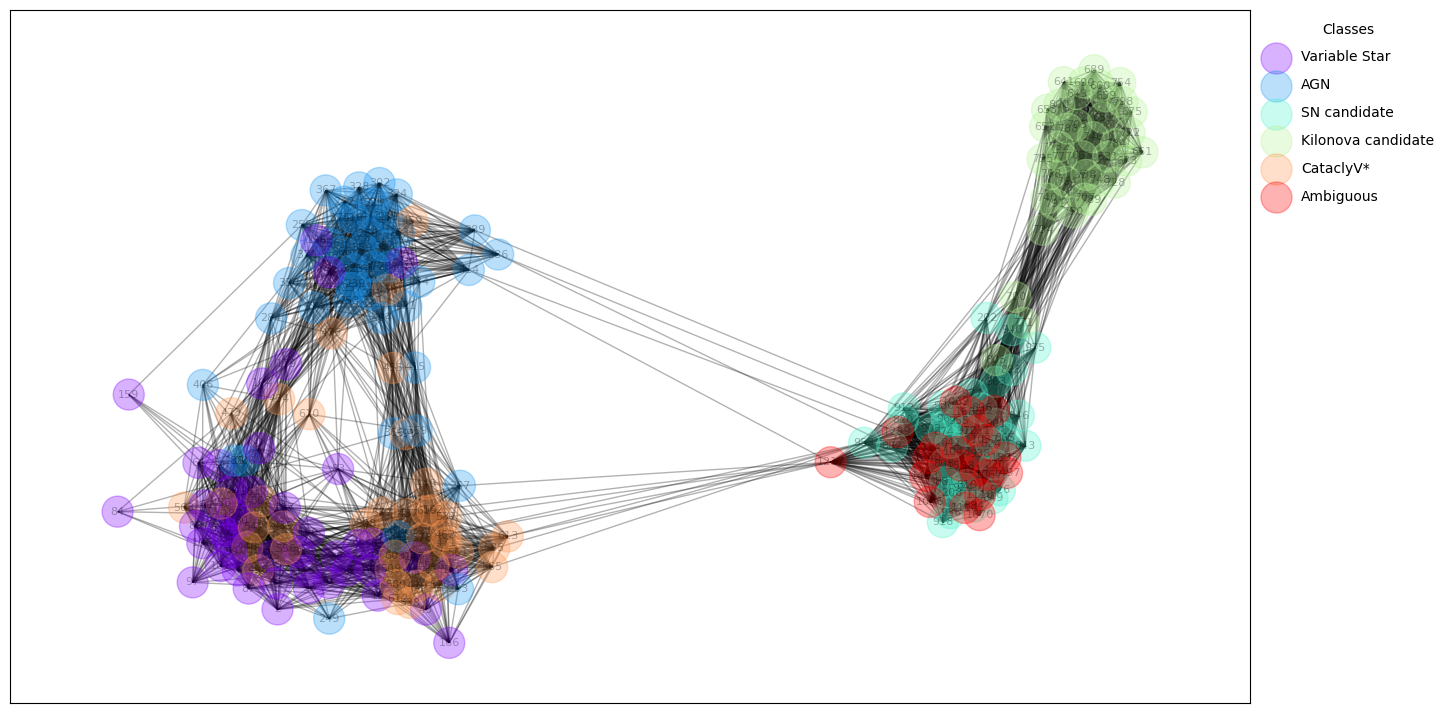

In [22]:
#defining the graph
G = nx.Graph()
G_temp = nx.Graph()
thresh = 0.5

#defining colors
plt.figure(figsize=(16,9))
color_map = []

#change color of each node according to their type
G_temp.add_nodes_from(df_filt_selected_sample2.index)

for node in G_temp:
        ele = name_meta[df['finkclass'][node]]
        color_map.append(ele)
        
        #add the node to the graph
        G.add_node(node)


for ind, key in enumerate(name_meta):
    plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)



dict_edges = {}
for i in range(len(df_filt_selected_sample2) + len(ambiguous_sample)):
    dict_edges[i] = {}
    
for i in range(len(df_filt_selected_sample2)):
    if df_filt_selected_sample2.index[i] in G.nodes():
        for j in range(i+1, len(df_filt_selected_sample2)):
            if df_filt_selected_sample2.index[j] in G.nodes():
                pred = float(net(torch.tensor([[df_filt_selected_sample2.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))
                if pred > 0.5:
                    G.add_edge(df_filt_selected_sample2.index[i], df_filt_selected_sample2.index[j])
            

                dict_edges[i][j] = pred
                dict_edges[j][i] = pred

#adding ambiguous edges
G.add_nodes_from(ambiguous_sample.index)
taille = len(df_filt_selected_sample2)

for i in range(len(ambiguous_sample)):
    color_map.append(name_meta["Ambiguous"])
    for j in range(len(df_filt_selected_sample2)):
        pred = float(net(torch.tensor([[ambiguous_sample.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))
        if pred > thresh:
            G.add_edge(ambiguous_sample.index[i], df_filt_selected_sample2.index[j])
            

            dict_edges[taille + i][j] = pred
            dict_edges[j][taille + i] = pred

count = 0
for i in range(len(ambiguous_sample)):
    for j in range(i + 1, len(ambiguous_sample)):
        pred = float(net(torch.tensor([[ambiguous_sample.iloc[i].to_list(), ambiguous_sample.iloc[j].to_list()]], dtype=torch.float32)))
        if pred > thresh:
            G.add_edge(ambiguous_sample.index[i], ambiguous_sample.index[j])
            count += 1

            dict_edges[taille + i][taille + j] = pred
            dict_edges[taille + j][taille + i] = pred
    
nx.draw_networkx(G, with_labels=True, node_color=color_map, node_size=500, alpha=0.3, font_size=8)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

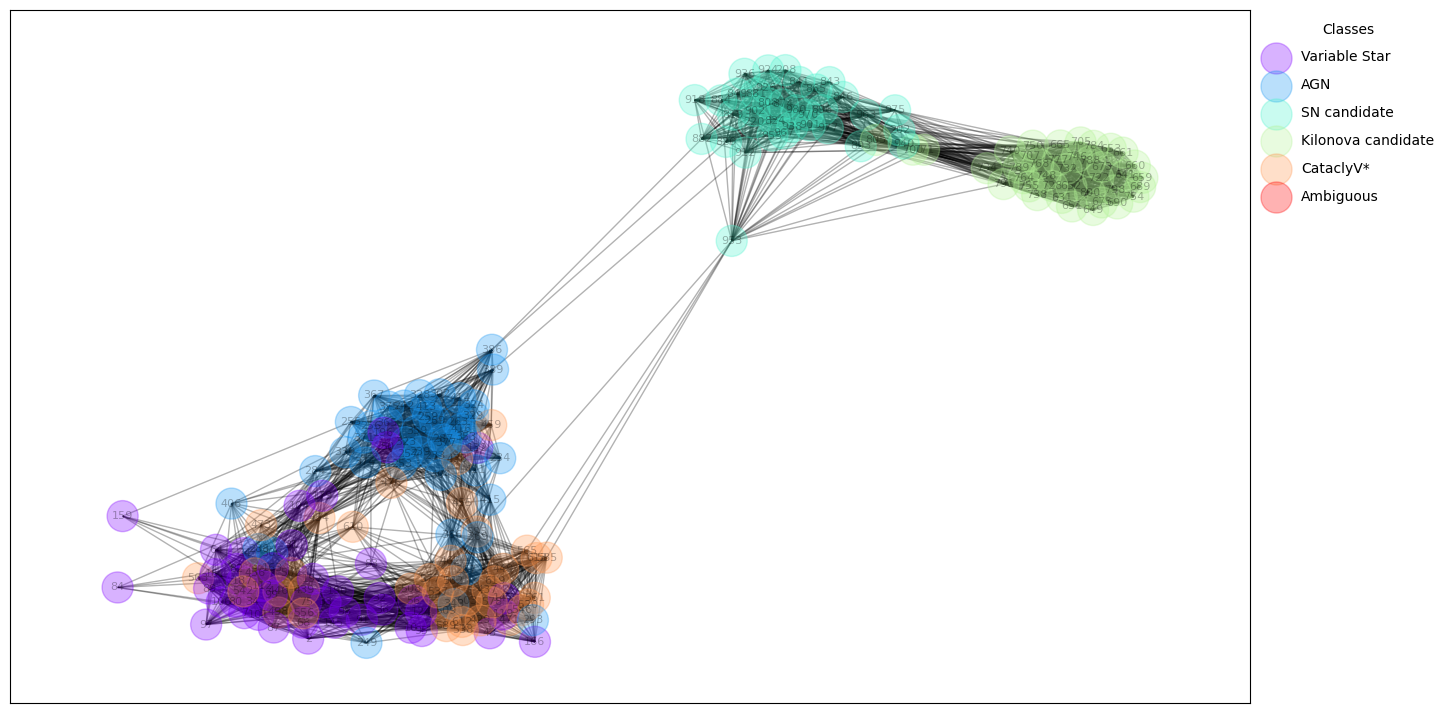

In [58]:
#defining the graph
G = nx.Graph()
G_temp = nx.Graph()

#defining colors
plt.figure(figsize=(16,9))
color_map = []

#change color of each node according to their type
G_temp.add_nodes_from(df_filt_selected_sample2.index)

for node in G_temp:
        ele = name_meta[df['finkclass'][node]]
        color_map.append(ele)
        
        #add the node to the graph
        G.add_node(node)


for ind, key in enumerate(name_meta):
    plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)



dict_edges = {}
for i in range(len(df_filt_selected_sample2) + len(anomaly)):
    dict_edges[i] = {}
    
for i in range(len(df_filt_selected_sample2)):
    if df_filt_selected_sample2.index[i] in G.nodes():
        for j in range(i+1, len(df_filt_selected_sample2)):
            if df_filt_selected_sample2.index[j] in G.nodes():
                pred = float(net(torch.tensor([[df_filt_selected_sample2.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))
                if pred > 0.5:
                    G.add_edge(df_filt_selected_sample2.index[i], df_filt_selected_sample2.index[j])
            

                dict_edges[i][j] = pred
                dict_edges[j][i] = pred


nx.draw_networkx(G, with_labels=True, node_color=color_map, node_size=500, alpha=0.3, font_size=8)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [82]:
dic = {'Variable Star': 0,
        'AGN': 0,
        'SN candidate': 0,
        'Kilonova candidate': 0,
        'CataclyV*': 0}

for node in G.nodes():
    pred_dic = {'Variable Star': 0,
            'AGN': 0,
            'SN candidate': 0,
            'Kilonova candidate': 0,
            'CataclyV*': 0}

    for couple in G.edges(node):
        a, b = couple
        if a == node:
            neighbor = b

        else:
            neighbor = a

        pred_dic[df['finkclass'][neighbor]] += 1

    pred = max(zip(pred_dic.values(), pred_dic.keys()))[1]

    if pred == df['finkclass'][node]:
        #print(node, "is well predicted")

        dic[df['finkclass'][node]] += 1


print("Number of good prediction:", sum(dic.values()), "over", len(G.nodes()), "ie", np.round(sum(dic.values())/len(G.nodes())*100, 2), "%")
    
for key, ind in dic.items():
    print(ind, "(over " + str(label_sample2.value_counts()[key]) + ") good prediction for", key, "ie", np.round(ind/label_sample2.value_counts()[key]*100, 2), "%")
        


Number of good prediction: 156 over 200 ie 78.0 %
27 (over 44) good prediction for Variable Star ie 61.36 %
35 (over 44) good prediction for AGN ie 79.55 %
35 (over 35) good prediction for SN candidate ie 100.0 %
36 (over 39) good prediction for Kilonova candidate ie 92.31 %
23 (over 38) good prediction for CataclyV* ie 60.53 %


In [185]:
#defining the graph
G_ano = nx.Graph()

#defining colors
color_map = []
thresh = 0.5
#change color of each node according to their type
G_ano.add_nodes_from(df_filt_selected_sample2.index)

for node in G: 
    ele = name_meta[df['finkclass'][node]]
    color_map.append(ele)

#add edges
dict_edges = {}
dict_scores = {}
for i in range(len(df_filt_selected_sample2) + len(anomaly) + len(ambiguous_sample)):
    dict_edges[i] = {}
    dict_scores[i] = {}
    
for i in range(len(df_filt_selected_sample2)):
    
    for j in range(i+1, len(df_filt_selected_sample2)):
        pred = float(net(torch.tensor([[df_filt_selected_sample2.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))
        if pred > thresh:
            G_ano.add_edge(df_filt_selected_sample2.index[i], df_filt_selected_sample2.index[j])
            

            dict_edges[i][j] = pred
            dict_edges[j][i] = pred

        dict_scores[i][j] = pred
        dict_scores[j][i] = pred


if True:
    #adding ambiguous edges
    taille = len(df_filt_selected_sample2)
    G_ano.add_nodes_from(ambiguous_sample.index)


    for i in range(len(ambiguous_sample)):
        color_map.append(name_meta["Ambiguous"])
        for j in range(len(df_filt_selected_sample2)):
            pred = float(net(torch.tensor([[ambiguous_sample.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))
            if pred > thresh:
                G_ano.add_edge(ambiguous_sample.index[i], df_filt_selected_sample2.index[j])
                

                dict_edges[taille + i][j] = pred
                dict_edges[j][taille + i] = pred

            dict_scores[taille + i][j] = pred
            dict_scores[j][taille + i] = pred

    for i in range(len(ambiguous_sample)):
        for j in range(i + 1, len(ambiguous_sample)):
            pred = float(net(torch.tensor([[ambiguous_sample.iloc[i].to_list(), ambiguous_sample.iloc[j].to_list()]], dtype=torch.float32)))
            if pred > thresh:
                G_ano.add_edge(ambiguous_sample.index[i], ambiguous_sample.index[j])
                

                dict_edges[taille + i][taille + j] = pred
                dict_edges[taille + j][taille + i] = pred

            dict_scores[taille + i][taille + j] = pred
            dict_scores[taille + j][taille + i] = pred
    

    #adding anomaly edges
                    
    count = 0
    for i in range(len(anomaly)):
        G_ano.add_node("Ano" + str(i))
        if i == 0:
            color_map.append("gold")
        else:
            color_map.append("black")
            
        count_meta = {'Variable Star': 0,
                'AGN': 0,
                'SN candidate': 0,
                'Ambiguous': 0,
                'Kilonova candidate': 0,
                'CataclyV*': 0}


        for j in range(len(ambiguous_sample)):
            pred = float(net(torch.tensor([[anomaly_filt_selected.iloc[i].to_list(), ambiguous_sample.iloc[j].to_list()]], dtype=torch.float32)))
            
            if pred > thresh:
                G_ano.add_edge("Ano" + str(i), ambiguous_sample.index[j])
                

                dict_edges[taille + len(ambiguous_sample) + i][taille + j] = pred
                dict_edges[taille + j][taille + len(ambiguous_sample) + i] = pred

                count_meta["Ambiguous"] += 1

            dict_scores[taille + len(ambiguous_sample) + i][taille + j] = pred
            dict_scores[taille + j][taille + len(ambiguous_sample) + i] = pred

        for j in range(len(df_filt_selected_sample2)):
            pred = float(net(torch.tensor([[anomaly_filt_selected.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))

            if pred > thresh:
                G_ano.add_edge("Ano" + str(i), df_filt_selected_sample2.index[j])
                

                dict_edges[taille + len(ambiguous_sample) + i][j] = pred
                dict_edges[j][taille + len(ambiguous_sample) + i] = pred

                count_meta[df['finkclass'][df_filt_selected_sample2.index[j]]] += 1

            dict_scores[taille + len(ambiguous_sample) + i][j] = pred
            dict_scores[j][taille + len(ambiguous_sample) + i] = pred

        for key, ind in count_meta.items():
            if ind != 0:
                print("Ano" + str(i), "is linked with", ind, key)


        count += sum(count_meta.values())

    print(count, "anomaly edges added over", int(len(df_filt_selected_sample2)**2), "possible edges ie", int((count/len(df_filt_selected_sample2)**2)*100), "%")

    count = 0
  
    for i in range(len(anomaly)):
        for j in range(i + 1, len(anomaly)):

            pred = float(net(torch.tensor([[anomaly_filt_selected.iloc[i].to_list(), anomaly_filt_selected.iloc[j].to_list()]], dtype=torch.float32)))

            if pred > thresh:
                G_ano.add_edge("Ano" + str(i), "Ano" + str(j))
                

                dict_edges[taille + len(ambiguous_sample) + i][taille + len(ambiguous_sample) + j] = pred
                dict_edges[taille + len(ambiguous_sample) + j][taille + len(ambiguous_sample) + i] = pred

                count += 1
                print("Ano" + str(i), "Ano" + str(j), "are linked !")

            dict_scores[taille + len(ambiguous_sample) + i][taille + len(ambiguous_sample) + j] = pred
            dict_scores[taille + len(ambiguous_sample) + j][taille + len(ambiguous_sample) + i] = pred

    
    print(count, "anomaly edges added over", int(len(anomaly) * (len(anomaly) - 1) / 2), "possible edges ie", int((count/(len(anomaly) * (len(anomaly) - 1) / 2)*100)), "%")


    

    #filtering the nodes without edges
    nodes_with_edges = []
    filtered_color = []
    i = 0

    at_least_one = False
    for node in G_ano.nodes():
        at_least_one = False
        if len(G_ano.edges(node)) > 0:
            nodes_with_edges.append(node)
            filtered_color.append(color_map[i])
            at_least_one = True

        if not at_least_one:
            print(node, "has no edges")
        

        i += 1

Ano1 is linked with 4 Variable Star
Ano1 is linked with 2 AGN
Ano1 is linked with 20 SN candidate
Ano1 is linked with 8 Ambiguous
Ano1 is linked with 1 Kilonova candidate
Ano1 is linked with 19 CataclyV*
Ano2 is linked with 1 Variable Star
Ano2 is linked with 4 CataclyV*
Ano3 is linked with 24 Variable Star
Ano3 is linked with 16 AGN
Ano3 is linked with 33 CataclyV*
Ano4 is linked with 4 Variable Star
Ano4 is linked with 37 AGN
Ano4 is linked with 5 CataclyV*
Ano5 is linked with 2 SN candidate
Ano5 is linked with 9 Kilonova candidate
Ano5 is linked with 3 CataclyV*
Ano6 is linked with 1 AGN
Ano6 is linked with 4 SN candidate
Ano6 is linked with 12 Kilonova candidate
Ano7 is linked with 10 Variable Star
Ano7 is linked with 19 CataclyV*
Ano8 is linked with 11 Variable Star
Ano8 is linked with 19 CataclyV*
Ano9 is linked with 5 Variable Star
Ano9 is linked with 11 AGN
Ano9 is linked with 2 SN candidate
Ano9 is linked with 1 Ambiguous
Ano9 is linked with 23 CataclyV*
Ano10 is linked with 1

/home/centos/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


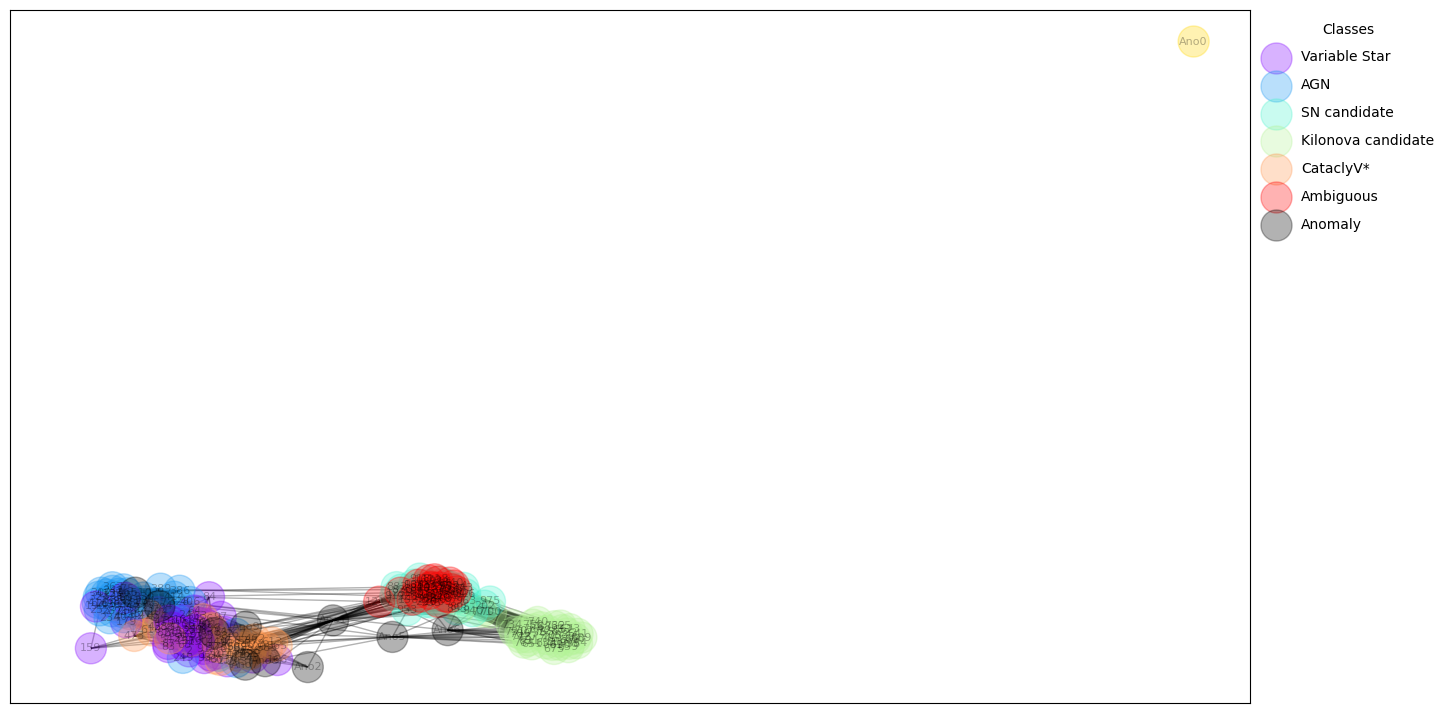

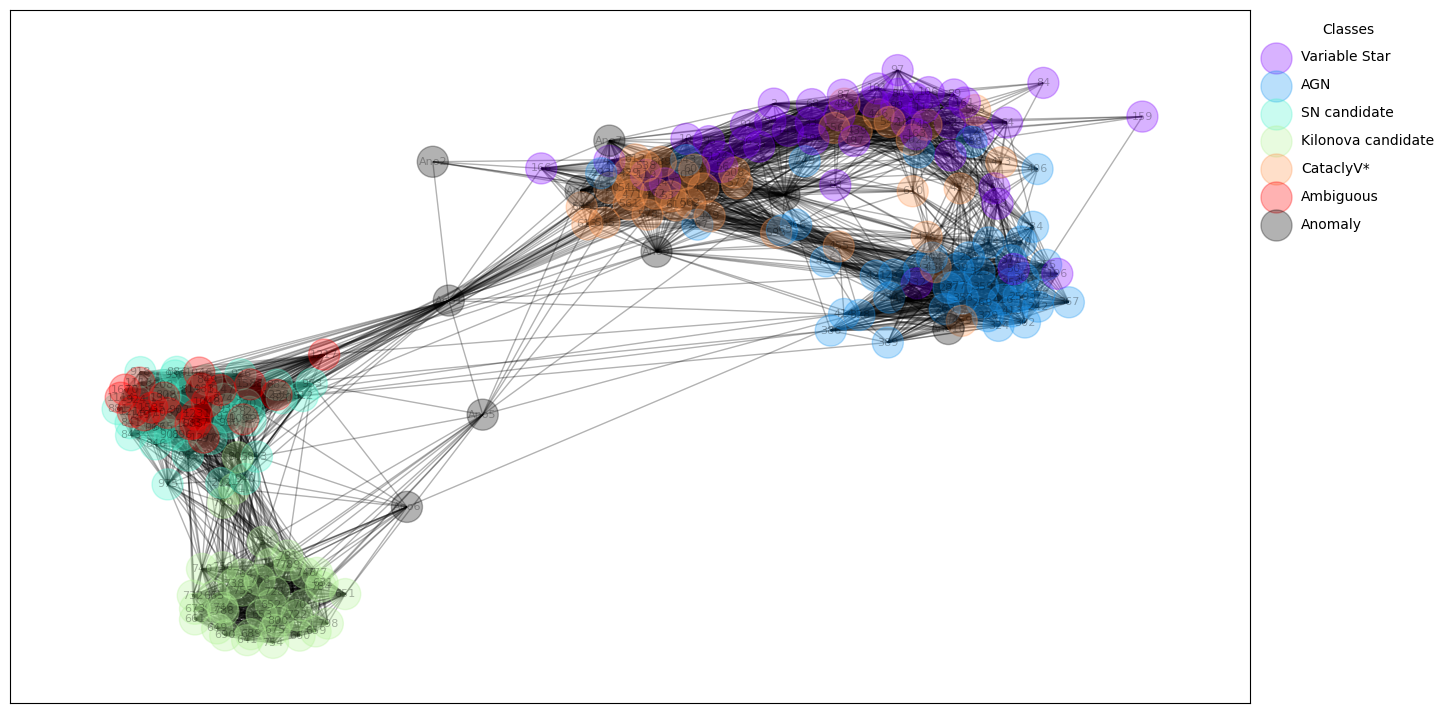

In [186]:
plt.figure(figsize=(16,9))

for ind, key in enumerate(name_meta):
    plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)

plt.scatter([],[], color="black", alpha=0.3, s=500, label="Anomaly")

nx.draw_networkx(G_ano, with_labels=True, node_color=color_map, node_size=500, alpha=0.3, font_size=8)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

plt.figure(figsize=(16,9))

for ind, key in enumerate(name_meta):
    plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)

plt.scatter([],[], color="black", alpha=0.3, s=500, label="Anomaly")
    
nx.draw_networkx(G_ano, with_labels=True, nodelist = nodes_with_edges, node_color=filtered_color, node_size=500, alpha=0.3, font_size=8)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [187]:
dic = {'Variable Star': 0,
        'AGN': 0,
        'SN candidate': 0,
        'Kilonova candidate': 0,
        'CataclyV*': 0}

for node in G_ano.nodes():
    go = False
    if type(node) == str:
        go = True

    else:
        if node > len(df):
            go = True
    
    if go:
        pred_dic = {'Variable Star': 0,
                'AGN': 0,
                'SN candidate': 0,
                'Kilonova candidate': 0,
                'CataclyV*': 0}

        for couple in G_ano.edges(node):
            a, b = couple
            if a == node:
                neighbor = b

            else:
                neighbor = a
            
            go2 = True
            if type(neighbor) == str:
                if "Ano" in neighbor:
                    go2 = False

            else:
                if neighbor > len(df):
                    go2 = False

            if go2:
                pred_dic[df['finkclass'][neighbor]] += 1

        pred = max(zip(pred_dic.values(), pred_dic.keys()))[1]

        
        #Anomalous
        if type(node) == str:
            node = oids[int(node[3:]) - 1]
            if sum(pred_dic.values()) > 0:
                proba = int(100*max(zip(pred_dic.values(), pred_dic.keys()))[0]/sum(pred_dic.values()))
                print(node, "is predicted (with " + str(proba) + "%", "confidence) as", pred, "(" + str(sum(pred_dic.values())), "links)" )

        
        if type(node) != str and False:
            node = "Ambiguous n°" + str(node - len(df))
            if sum(pred_dic.values()) > 0:
                proba = int(100*max(zip(pred_dic.values(), pred_dic.keys()))[0]/sum(pred_dic.values()))
                print(node, "is predicted (with " + str(proba) + "%", "confidence) as", pred, "(" + str(sum(pred_dic.values())), "links)" )


ZTF18aazndjw is predicted (with 43% confidence) as SN candidate (46 links)
ZTF17aabpimd is predicted (with 80% confidence) as CataclyV* (5 links)
ZTF18aazrofd is predicted (with 45% confidence) as CataclyV* (73 links)
ZTF18abizzqe is predicted (with 80% confidence) as AGN (46 links)
ZTF18aakhgsc is predicted (with 64% confidence) as Kilonova candidate (14 links)
ZTF18abghrpw is predicted (with 70% confidence) as Kilonova candidate (17 links)
ZTF19aascumi is predicted (with 65% confidence) as CataclyV* (29 links)
ZTF19aawhnhy is predicted (with 63% confidence) as CataclyV* (30 links)
ZTF20aaspijy is predicted (with 56% confidence) as CataclyV* (41 links)
ZTF19acsbxgd is predicted (with 88% confidence) as AGN (27 links)


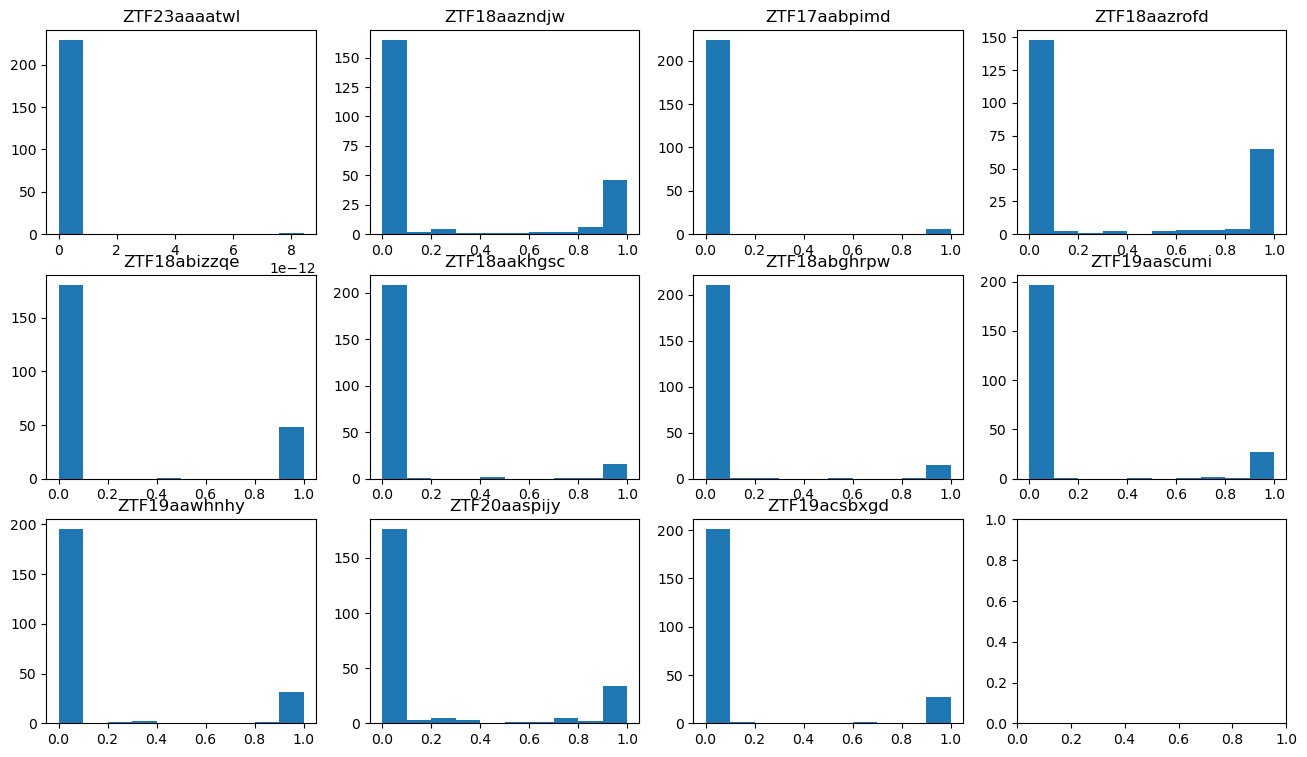

In [192]:
#create a 3*4 subfigure
fig, axs = plt.subplots(3, 4, figsize=(16,9))

for i in range(len(anomaly)):
    #plot dict_scores[i].values() on the ith subplot
    axs[i//4, i%4].hist(dict_scores[220+i].values())
    if i > 0:
        axs[i//4, i%4].set_title(oids[i-1])

    if i == 0:
        axs[i//4, i%4].set_title("ZTF23aaaatwl")


## Mesure de performance

In [61]:
print(label_sample2.value_counts())

tab_ele = label_sample2.value_counts()
theorical = 0

for key, ind in tab_ele.items():
    theorical += int(ind*(ind-1)/2)

print("Number of link if each alert is connected to all and only all alerts with the same class :", theorical)

AGN                   44
Variable Star         44
Kilonova candidate    39
CataclyV*             38
SN candidate          35
Name: finkclass, dtype: int64
Number of link if each alert is connected to all and only all alerts with the same class : 3931


In [62]:
count = 0

for edge in G.edges():

    if not ("Ano" in str(edge[0]) or "Ano" in str(edge[1])):

        if df['finkclass'][edge[0]] == df['finkclass'][edge[1]]:
            count += 1

print("Number of good link in the graph :", count, "number of link in the graph :", len(G.edges()))
print("Ratio:", count/len(G.edges()))

Number of good link in the graph : 2436 number of link in the graph : 3928
Ratio: 0.620162932790224


# Tune the Graph

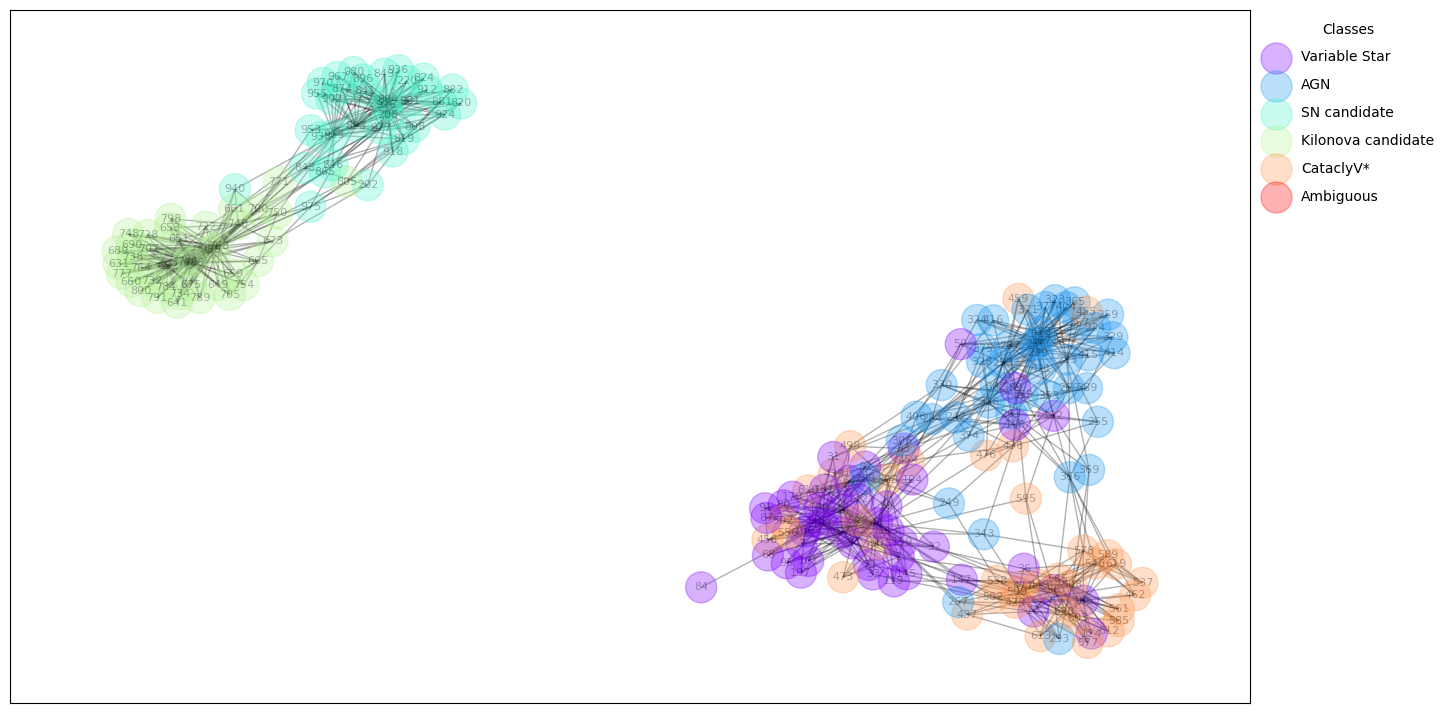

In [71]:
n = 5

#defining the graph
G = nx.Graph()

#defining colors
plt.figure(figsize=(16,9))
color_map = []

#change color of each node according to their type
G.add_nodes_from(df_filt_selected_sample2.index)

for node in G: 
    ele = name_meta[df['finkclass'][node]]
    color_map.append(ele)

for ind, key in enumerate(name_meta):
    plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)

#add edges 
for i in range(len(df_filt_selected_sample2)): 
    if len(dict_edges[i]) <= number_max_of_edges:
        for ind, key, in enumerate(dict_edges[i]):
            G.add_edge(df_filt_selected_sample2.index[i], df_filt_selected_sample2.index[key])

    else:
        cles_triees = sorted(dict_edges[i], key=dict_edges[i].get, reverse=True)
        n_cles = cles_triees[:n]
        
        if n < len(cles_triees) and dict_edges[cles_triees[n]] == 1:
            valeur_un = [cle for cle in cles_triees[n:] if dictionnaire[cle] == 1]
            n_cles.extend(valeur_un)

        for key in n_cles:
            G.add_edge(df_filt_selected_sample2.index[i], df_filt_selected_sample2.index[key])

            

nx.draw_networkx(G, with_labels=True, node_color=color_map, node_size=500, alpha=0.3, font_size=8)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [72]:
count = 0

for edge in G.edges():
    if "Ano" not in edge:
        if df['finkclass'][edge[0]] == df['finkclass'][edge[1]]:
            count += 1
 
print("Number of good link in the graph :", count, "number of link in the graph :", len(G.edges()))
print("Ratio:", count/len(G.edges()))

Number of good link in the graph : 643 number of link in the graph : 882
Ratio: 0.7290249433106576


In [65]:
#save the model net

folder = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

torch.save(net.state_dict(), 'results/models/model.pt')
np.savetxt('results/models/errors.csv', error, delimiter=',')


# Graph Neural Network

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv

# Définition du graphe de train

convert_class = {'Variable Star': 0,
 'AGN': 1,
 'SN candidate': 2,
 'Ambiguous': 3,
 'Kilonova candidate': 4}

def convert_class_to_int(x):
    return convert_class[x]


x = torch.tensor([df_filt_selected_sample.index], dtype=torch.float)  # Caractéristiques des nœuds
y = torch.tensor([label_sample.apply(convert_class_to_int).to_numpy()], dtype=torch.float)
start = []
end = []
classe = []

for i in range(len(df_filt_selected_sample)):
    for j in range(i + 1, len(df_filt_selected_sample)):
        pred = float(net(torch.tensor([[df_filt_selected_sample.iloc[i].to_list(), df_filt_selected_sample.iloc[j].to_list()]], dtype=torch.float32)))
        if pred > 0.5:
            start.append(i)
            start.append(j)
            end.append(i)
            end.append(j)

edge_index = torch.tensor([start, end], dtype=torch.long)  # Indices d'arête

from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, y=y)

class GNNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Instanciation du modèle
model = GNNClassifier(in_channels=200, hidden_channels=512, out_channels=200)

# Définition de la fonction de perte et de l'optimiseur
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entraînement du modèle
for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

# Prédiction sur de nouvelles données
x = torch.tensor([df_filt_selected_sample2.index], dtype=torch.float)  # Caractéristiques des nœuds
y = torch.tensor([label_sample2.apply(convert_class_to_int).to_numpy()], dtype=torch.float)
start = []
end = []
classe = []

for i in range(len(df_filt_selected_sample2)):
    for j in range(i + 1, len(df_filt_selected_sample2)):
        pred = float(net(torch.tensor([[df_filt_selected_sample.iloc[i].to_list(), df_filt_selected_sample.iloc[j].to_list()]], dtype=torch.float32)))
        if pred > 0.5:
            start.append(i)
            start.append(j)
            end.append(i)
            end.append(j)

edge_index = torch.tensor([start, end], dtype=torch.long)



model.eval()
with torch.no_grad():
    new_data = Data(x=torch.tensor([df_filt_selected_sample.index], dtype=torch.float),
                    edge_index=edge_index)
    out = model(new_data)
    predicted_classes = torch.argmax(out, dim=1)
    print(predicted_classes)

tensor([187])


In [70]:
out

tensor([[  481.4625,  1960.9386,  -962.3068,  2906.1426, -8477.8184,  1052.7524,
           433.1138,  1491.6824,  1056.2839,  1874.4457,  1156.9005,   571.7602,
           547.2077,  1125.4286,  -382.6735, -1263.7432,  2339.6448,  2829.8164,
          2390.1848, -1153.2687,  1157.4602,  1526.7775,  1517.1355,   683.0297,
          -274.3651,  1934.2010,  2023.5332,   742.4426,   548.8695,  1780.0167,
           762.5834,   999.1404,   569.0972,  1429.6692,   716.6708,  1894.7874,
          1573.3333,   252.3012,  1251.8092,  1756.5549,  1769.3933,  1228.9149,
           984.6918,  2215.7009,   738.8901,  1608.0228, -1426.4783,  1243.5060,
           572.8425,  1695.1166,   474.1576,  1457.8490,   855.7292,  -435.9915,
          1206.0485,  1294.2516,   718.6974,  1602.6587,  2142.9514,  1372.7369,
          1668.5361,  -393.0234,  1071.2053,  1463.9146,  1381.8804,   809.6849,
          1229.3679,  2555.6575,  1484.8708,   402.5022,   771.1758,  2428.2566,
           796.7025,  2753.2